In [1]:
#Imports
import numpy as np
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

In [2]:
#Preferences
%matplotlib inline

In [3]:
mobile = tf.keras.applications.mobilenet.MobileNet()

2023-07-24 13:39:14.370793: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def prepare_image(file):
    img_path = "data/MobileNet-samples/"
    img = image.load_img(img_path + file, target_size = (224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

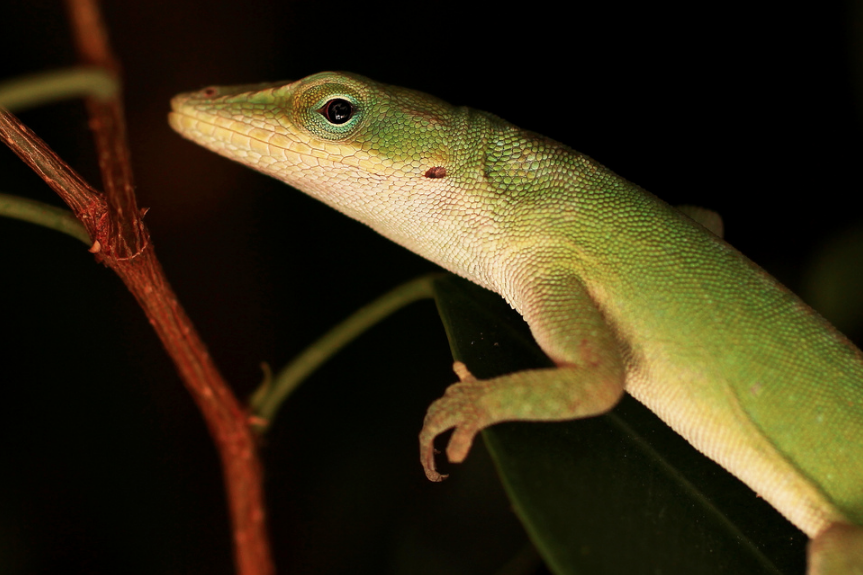

In [5]:
from IPython.display import Image
Image(filename="data/MobileNet-samples/1.png", width=300, height=200)

In [6]:
preprocessed_image = prepare_image("1.png")
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n01693334', 'green_lizard', 0.54804564),
  ('n01682714', 'American_chameleon', 0.45133483),
  ('n01694178', 'African_chameleon', 0.00026421063),
  ('n01689811', 'alligator_lizard', 0.000115279974),
  ('n01675722', 'banded_gecko', 6.598082e-05)]]

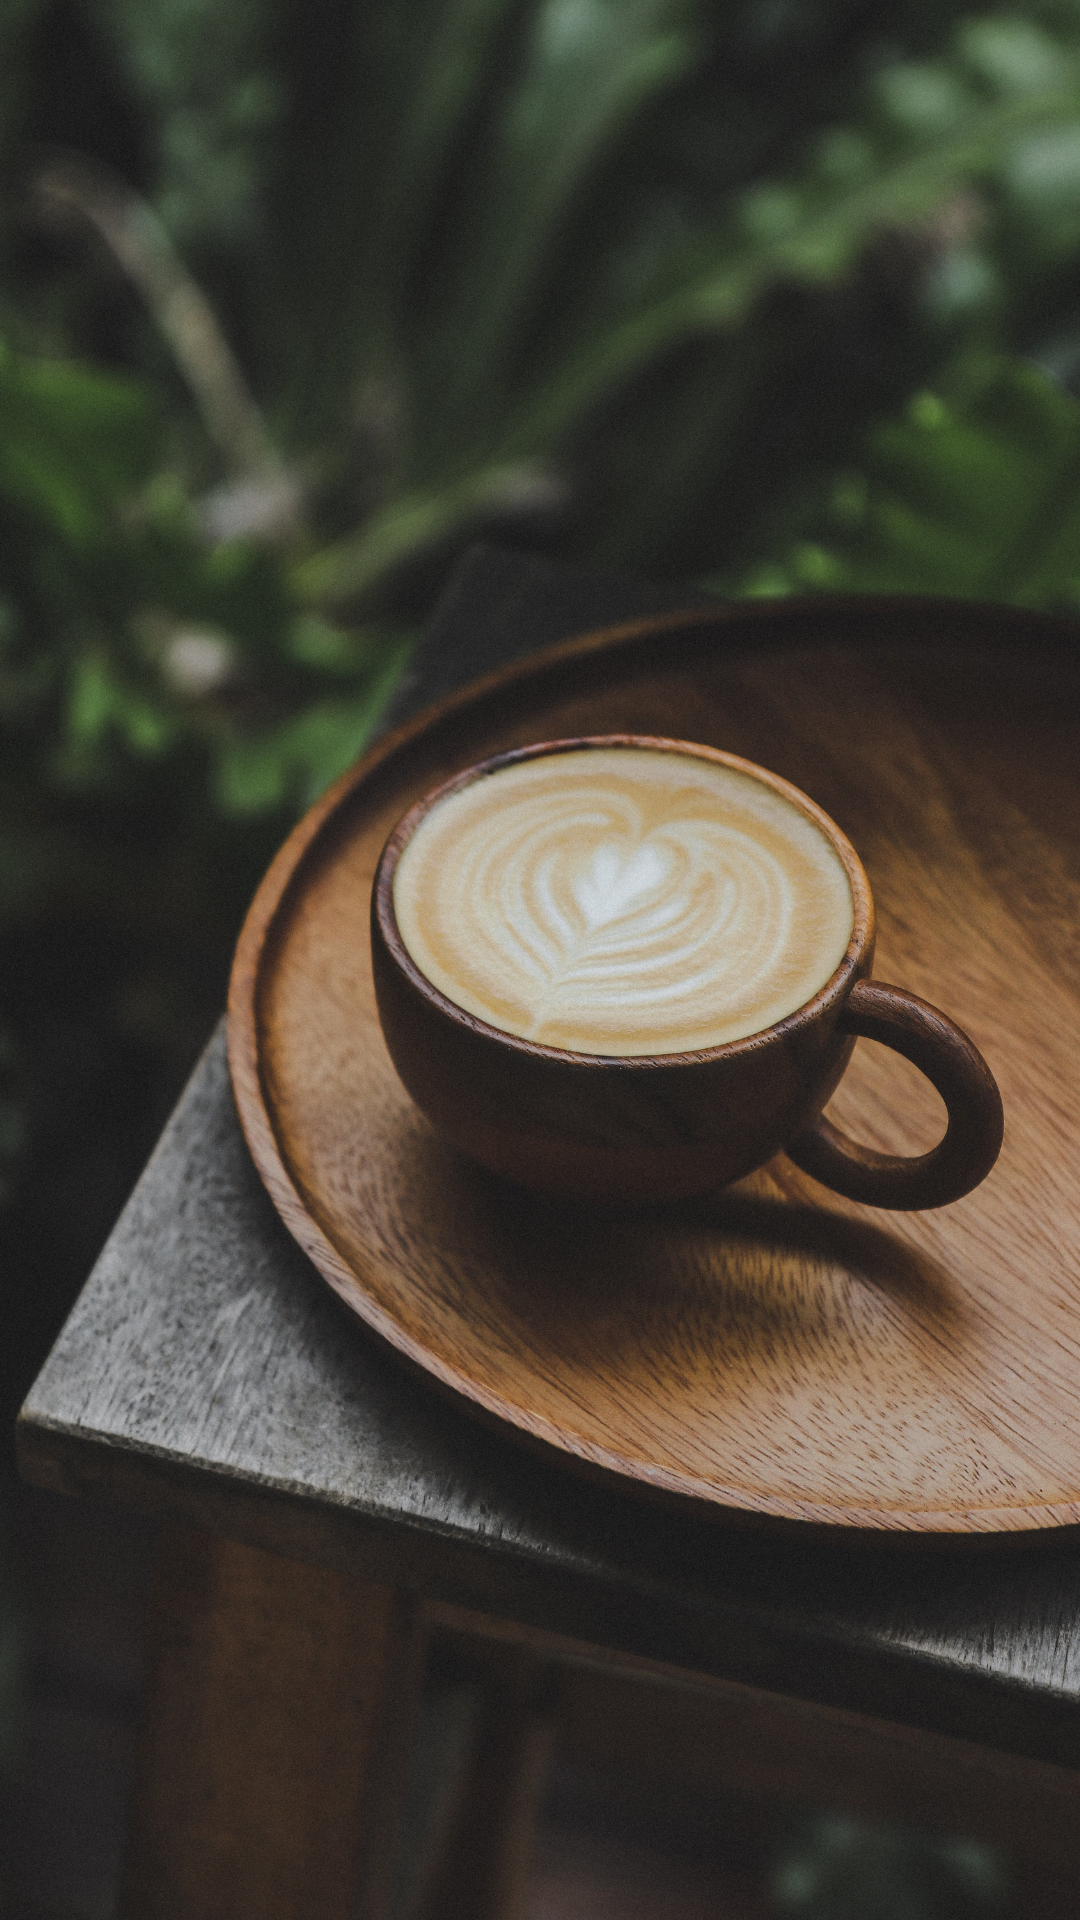

In [7]:
Image(filename="data/MobileNet-samples/2.png", width=300, height=200)

#### Test to see if it works with jpg files:

In [8]:
preprocessed_image = prepare_image("2.png")
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n01944390', 'snail', 0.13216744),
  ('n03109150', 'corkscrew', 0.07859945),
  ('n07930864', 'cup', 0.07583913),
  ('n04579432', 'whistle', 0.065411404),
  ('n02877765', 'bottlecap', 0.06417854)]]

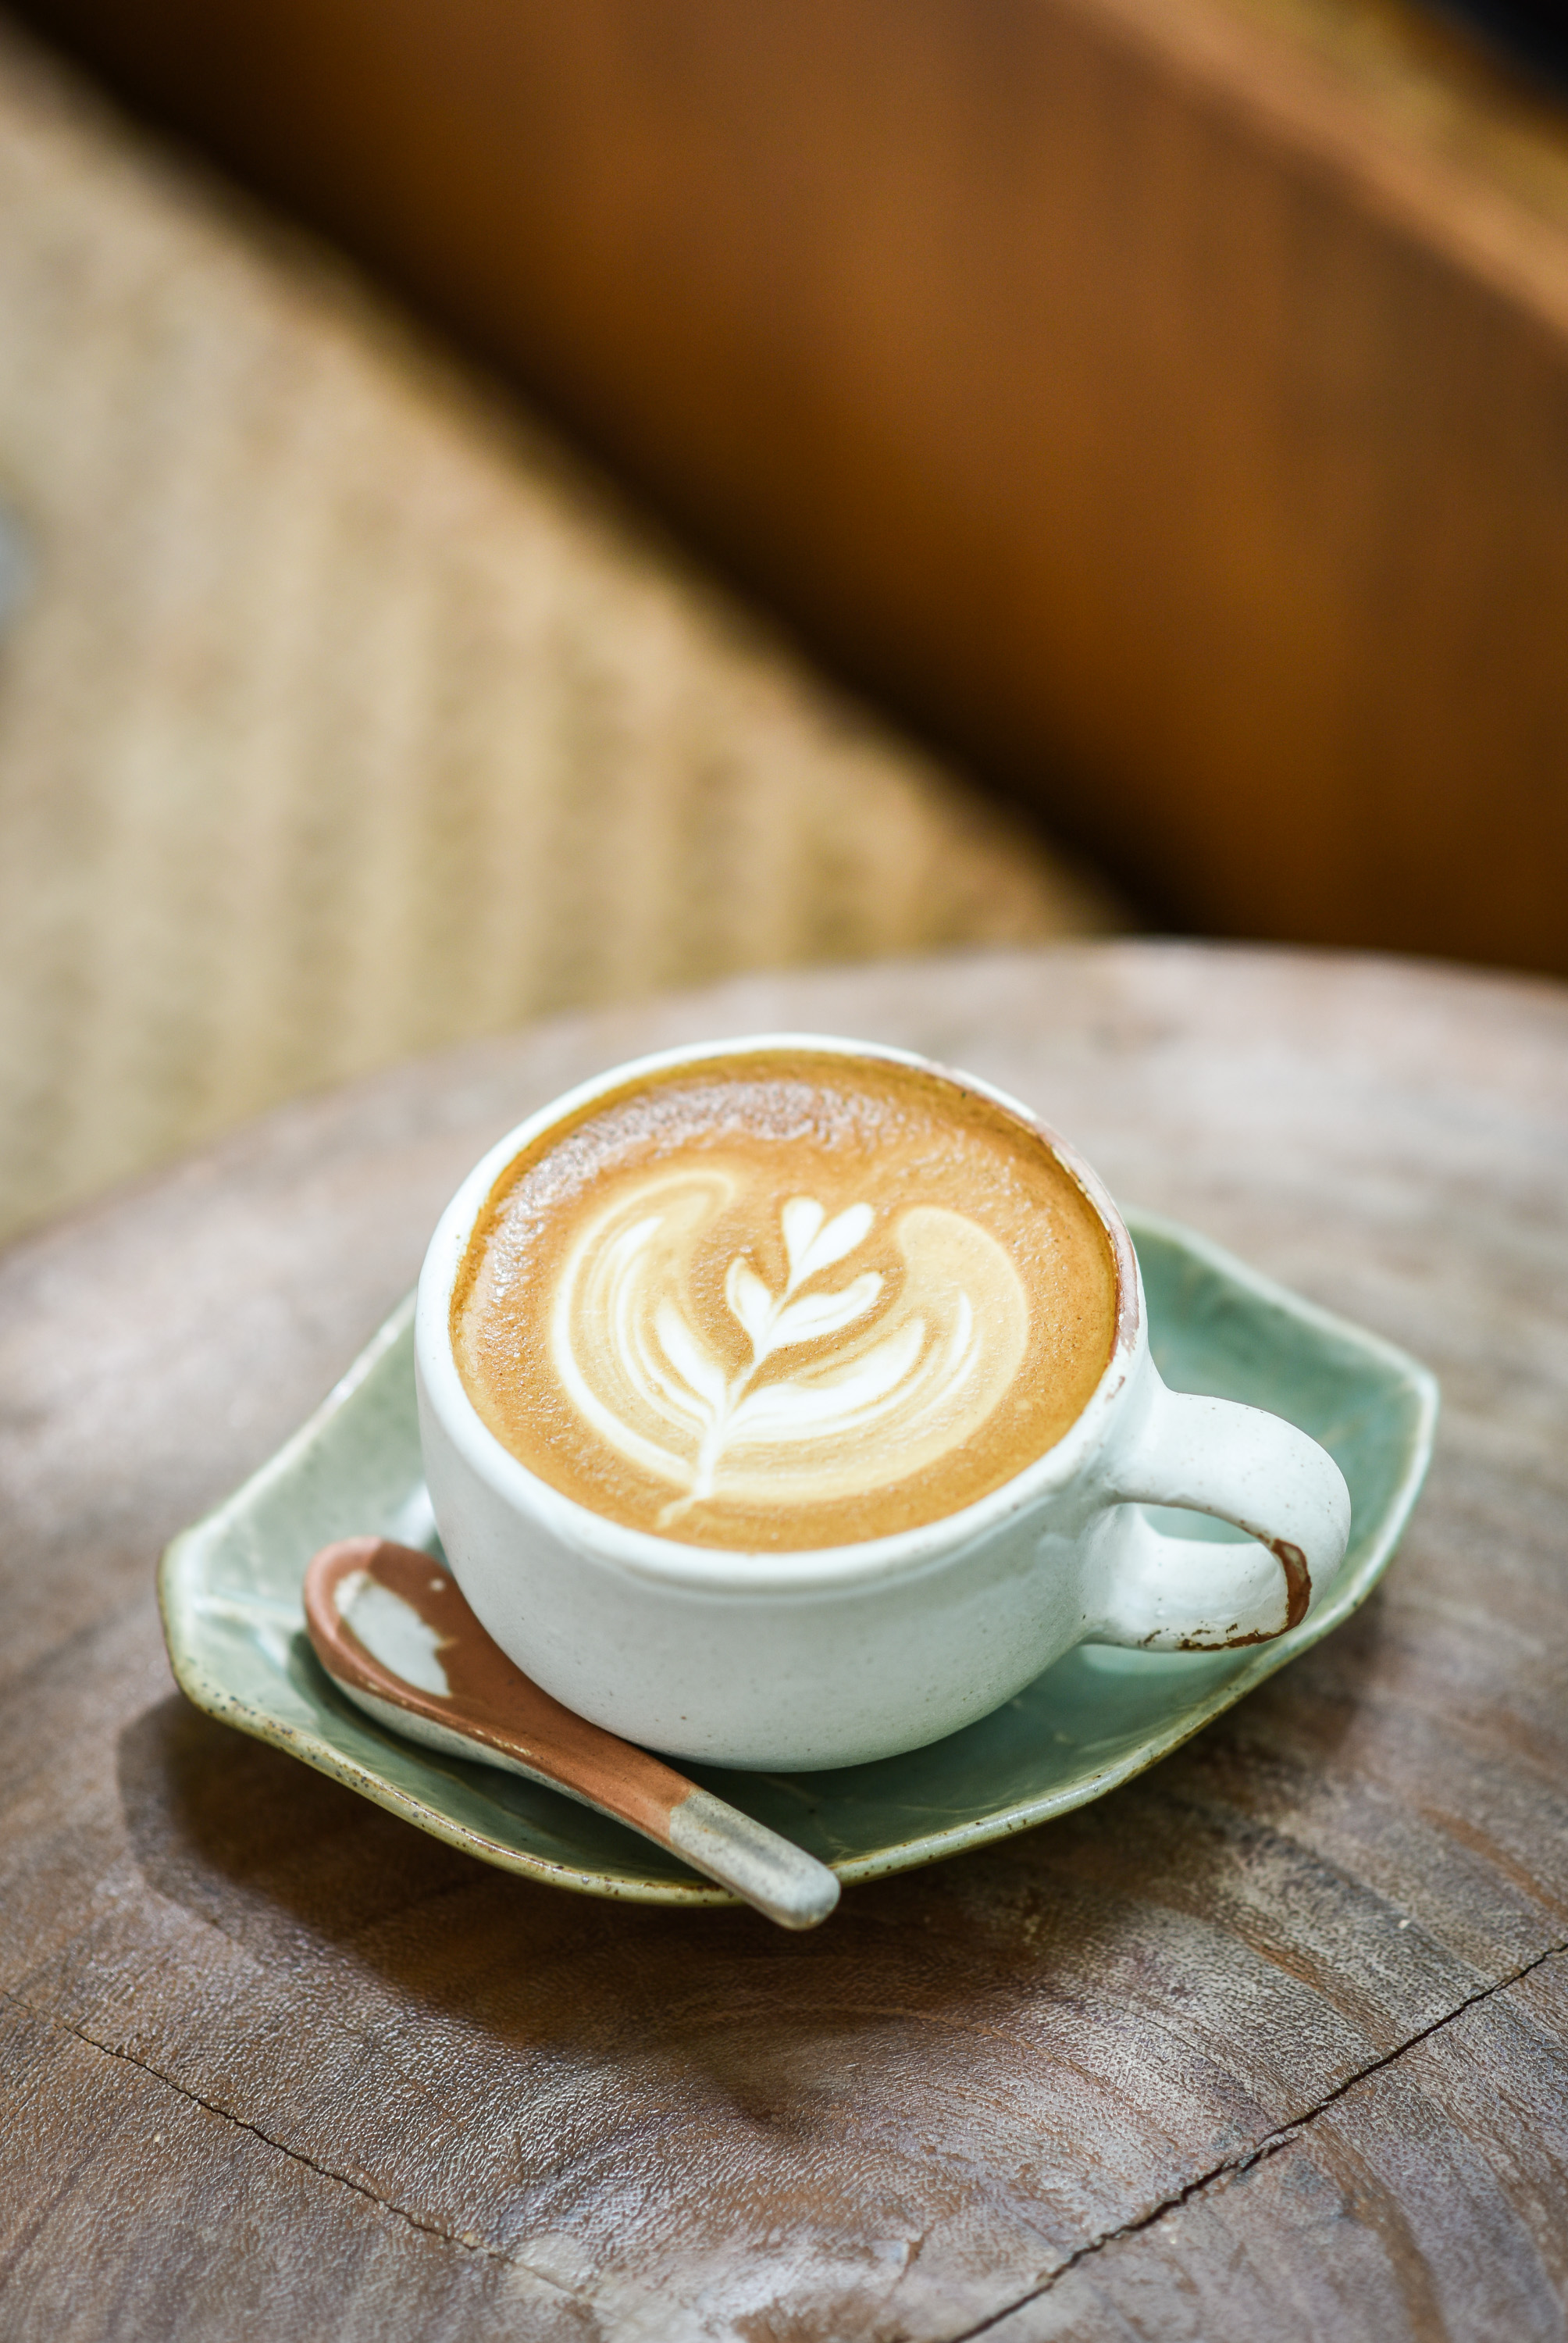

In [9]:
Image(filename="data/MobileNet-samples/2.jpg", width=300, height=200)

In [10]:
preprocessed_image = prepare_image("2.jpg")
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n07920052', 'espresso', 0.44439834),
  ('n03584254', 'iPod', 0.061899956),
  ('n02877765', 'bottlecap', 0.056610983),
  ('n07930864', 'cup', 0.05258689),
  ('n03690938', 'lotion', 0.037554856)]]

### Fine-tuning MobileNet model

In [11]:
os.chdir("data/Sign-Language-Digits-Dataset")
if os.path.isdir("train/0/") is False:
    os.mkdir("train")
    os.mkdir("val")
    os.mkdir("test")

    for i in range(0, 10):
        shutil.move(f"{i}", "train")
        os.mkdir(f"val/{i}")
        os.mkdir(f"test/{i}")

        val_samples = random.sample(os.listdir(f"train/{i}"), 30)
        for j in val_samples:
            shutil.move(f"train/{i}/{j}", f"val/{i}")

        test_samples = random.sample(os.listdir(f"train/{i}"), 5)
        for k in test_samples:
            shutil.move(f"train/{i}/{k}", f"test/{i}")

os.chdir("../..")

In [12]:
train_path = "data/Sign-Language-Digits-Dataset/train"
val_path = "data/Sign-Language-Digits-Dataset/val"
test_path = "data/Sign-Language-Digits-Dataset/test"

In [18]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)

Found 1712 images belonging to 10 classes.


In [17]:
val_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=val_path, target_size=(224,224), batch_size=10)

Found 300 images belonging to 10 classes.


In [16]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 50 images belonging to 10 classes.


In [19]:
assert train_batches.n == 1712
assert val_batches.n == 300
assert test_batches.n == 50
assert train_batches.num_classes == val_batches.num_classes == test_batches.num_classes == 10

### Modify Model

In [20]:
mobile = tf.keras.applications.mobilenet.MobileNet()